In [1]:
#!pip install -U tqdm

In [2]:
import os
import pandas as pd
import numpy as np
import random
from random import shuffle
import matplotlib.pyplot as plt
from pandas.tools.plotting import table
from tqdm import tqdm_notebook, tnrange

In [3]:
path = "./data/sol.out"

In [4]:
shift_schedule = pd.read_csv(path, delim_whitespace=True, header=-1)

In [5]:
shift_schedule.columns = ['employe', 'poste', 'quantite', 'tâche', 'num_rota', 'debut', 'heure_debut', 'fin', 'heure_fin', 'parentheses']

In [6]:
#sont gardées seulement les rangées pour les rotations d'employés (pas de jours de congés ou de formation inclus)
shift_work = shift_schedule[shift_schedule['tâche'] == 'TRP']

In [7]:
#on garde les colonnes pertinentes pour le projet
shift_assignments = shift_work[['employe', 'num_rota']]

In [ ]:
#permet de déterminer les targets (rotations suivantes) pour chaque rotation lorsqu'en position initiale 
shift_assignments['next'] = None
shift_assignments['next2'] = None   

In [9]:
shift_assignments.index = range(23682)

In [10]:
shifts = np.array(shift_assignments)

In [11]:
#shifts

In [12]:
for i in range(shifts.shape[0] - 1):
    shifts[i, 2] = shifts[i+1, 1]
for i in range(shifts.shape[0] -2):
    shifts[i, 3] = shifts[i+2, 1]

In [13]:
#shifts

In [14]:
#pour énumérer les rotations uniques, utile pour la création de one-hot vectors
code_rota = list(set(shift_assignments['num_rota']))
code_to_ix = {code:i for i,code in enumerate(code_rota)}

In [15]:
#conversion des codes en nombres entiers (permet embedding et one hot vector)
shifts_filt = [shifts[s, :] for s in range(len(shifts)-2) if shifts[s, 0] == shifts[s+2, 0]]
inputs_0 = [code_to_ix[code] for code in [i[1] for i in shifts_filt]]
inputs_1 = [code_to_ix[code] for code in [i[2] for i in shifts_filt]]
inputs_2 = [code_to_ix[code] for code in [i[3] for i in shifts_filt]]
inputs_whole = list(zip(inputs_0, inputs_1, inputs_2))
#print(inputs_whole)

In [16]:
shuffle(inputs_whole)
#print(inputs_whole)

In [17]:
inputs_train = inputs_whole[0:15547]
inputs_test = inputs_whole[15548:19434]

In [37]:
hidden_size = 100
learning_rate = 1e-2
rota_size = len(code_rota)
nb_epochs = 100
minibatch_size = len(inputs_whole)//200
losses_train = []
losses_test = []

In [38]:
Wxh = np.random.randn(hidden_size, rota_size)*0.01
Whh = np.random.randn(hidden_size, hidden_size)*0.01
Why = np.random.randn(rota_size, hidden_size)*0.01
bh = np.zeros((hidden_size, 1))
by = np.zeros((rota_size, 1))

In [39]:
# Source: https://gist.github.com/karpathy/d4dee566867f8291f086
# Post: http://karpathy.github.io/2015/05/21/rnn-effectiveness/
#le code est largement inspiré de cette source, mais a été adapté pour les besoins de notre projet.
def lossFun(inputs, hprev):
    xs, hs, ys, ps = {}, {}, {}, {}
    #xs, hs, ys, ps = [], [], [], []
    hs[-1] = np.copy(hprev)
    loss = 0
    
    xs[0] = np.zeros((rota_size, 1))
    xs[0][inputs[0]] = 1
    
    #propagation forward
    for t in range(2):
        target = np.zeros((rota_size, 1))
        target[inputs[t+1]] = 1
        
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)
        ys[t] = np.dot(Why, hs[t]) + by
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
        loss += -np.log(np.dot(ps[t].T,target))
        
        #input suivant assigné selon l'indice correspondant à la probabilité maximale
        xs[t+1] = np.zeros((rota_size, 1))
        ix = np.argmax(ps[t])
        xs[t+1][ix] =1
        
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    
    #backpropagation avec BTT
    for t in range(1, -1, -1):
        dy = np.copy(ps[t])
        dy[inputs[t+1]] -= 1
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext
        dhraw = (1 - hs[t] * hs[t]) * dh
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
    
    #pour éviter explosion des gradients
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam)
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-2]

#pour évaluer fonction de perte de l'ensemble test sans ajustement de gradient
def justLoss(inputs, hprev):
    xs, hs, ys, ps = {}, {}, {}, {}
    #xs, hs, ys, ps = [], [], [], []
    hs[-1] = np.copy(hprev)
    loss = 0
    
    xs[0] = np.zeros((rota_size, 1))
    xs[0][inputs[0]] = 1
    
    for t in range(2):
        target = np.zeros((rota_size, 1))
        target[inputs[t+1]] = 1
        
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)
        ys[t] = np.dot(Why, hs[t]) + by
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t]))
        loss += -np.log(np.dot(ps[t].T,target))
        
        xs[t+1] = np.zeros((rota_size, 1))
        ix = np.argmax(ps[t])
        xs[t+1][ix] =1
        
    return loss
        

In [40]:
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by)

for epoch in tnrange(nb_epochs, desc='processing epoch'):    
    
    #afin de considérer une mise à jour par minilot
    for i in tnrange(0, len(inputs_train), minibatch_size, desc='inputs_whole', leave=False):
        inputs_select = inputs_train[i:(i+minibatch_size)]
        loss, dWxh, dWhh, dWhy, dbh, dby = [0, 0, 0, 0, 0, 0]
        hprev_0 = np.zeros((hidden_size,1))
        hprev = np.zeros((hidden_size,1))
        
        for j in range(len(inputs_select)):
            res = [q/len(inputs_select) for q in lossFun(inputs_select[j], hprev_0)]
            loss += res[0]
            dWxh += res[1]
            dWhh += res[2]
            dWhy += res[3]
            dbh += res[4]
            dby += res[5]
            hprev += res[6]
        
        #mise à jour des gradients
        for param, dparam, mem in zip([Wxh, Whh, Why, bh, by], [dWxh, dWhh, dWhy, dbh, dby], [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8)
            
    print(loss)
    losses_train.append(loss)

    loss = 0
    hprev_0 = np.zeros((hidden_size,1))
    hprev = np.zeros((hidden_size,1))
     
    #pour les fonctions de perte de test
    for l in range(len(inputs_test)):
        res = [k/len(inputs_test) for k in justLoss(inputs_test[l], hprev_0)]
        loss += res[0]
    print(loss)
    losses_test.append(loss)

HBox(children=(IntProgress(value=0, description='processing epoch'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 10.03142165]]
[ 10.22165926]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.84444554]]
[ 10.06038284]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.69205131]]
[ 9.92013673]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.62385632]]
[ 9.8591157]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.58182403]]
[ 9.82985835]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.54526607]]
[ 9.81316914]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.54322764]]
[ 9.79593206]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.51626405]]
[ 9.78171689]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.49652258]]
[ 9.77131659]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.4789405]]
[ 9.76192194]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.49489128]]
[ 9.75622085]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.47147861]]
[ 9.75183512]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.45134497]]
[ 9.74687712]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.43534306]]
[ 9.74205303]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.42272473]]
[ 9.7363279]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.41357005]]
[ 9.73046414]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.40555813]]
[ 9.72239149]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.40444355]]
[ 9.71662573]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.39843212]]
[ 9.71065231]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.39266136]]
[ 9.70588833]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.38626665]]
[ 9.70155025]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.38056484]]
[ 9.69473894]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.37514563]]
[ 9.69012241]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.37035595]]
[ 9.68756167]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.36557097]]
[ 9.68419409]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.35502244]]
[ 9.68025916]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.34751333]]
[ 9.67708654]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.34357135]]
[ 9.67278109]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.3394242]]
[ 9.66931208]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.33541782]]
[ 9.66598851]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.33124045]]
[ 9.66284932]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.32725677]]
[ 9.65995624]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.32306961]]
[ 9.65742421]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.31869147]]
[ 9.65475768]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.31417761]]
[ 9.65270239]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.31000609]]
[ 9.649635]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.31470324]]
[ 9.64733632]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.31092087]]
[ 9.64558116]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.29549864]]
[ 9.64443371]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.29148724]]
[ 9.6430306]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.28737658]]
[ 9.64138873]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.28285675]]
[ 9.63930387]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.27860097]]
[ 9.6380753]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.27401198]]
[ 9.63599777]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.26925757]]
[ 9.63533041]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.26494911]]
[ 9.63485391]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.2757494]]
[ 9.63391942]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.26978634]]
[ 9.63268166]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.26421267]]
[ 9.63133867]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.25884167]]
[ 9.63106765]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.25310492]]
[ 9.62958499]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.24751191]]
[ 9.62926985]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.24653363]]
[ 9.62823547]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.24089029]]
[ 9.62770887]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.23542629]]
[ 9.62758203]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.23019998]]
[ 9.62545949]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.22483715]]
[ 9.62482757]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.21959723]]
[ 9.62440834]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.21493654]]
[ 9.62394214]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.20991335]]
[ 9.62351149]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.20525001]]
[ 9.62267956]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.20354756]]
[ 9.62198535]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.19863874]]
[ 9.62130434]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.1881419]]
[ 9.62111909]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.18283806]]
[ 9.62094982]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.19307565]]
[ 9.62099415]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.18493379]]
[ 9.62172901]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.17804893]]
[ 9.62058976]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.17358201]]
[ 9.61989799]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.16645151]]
[ 9.62293683]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.14967087]]
[ 9.62276242]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.14557379]]
[ 9.62192045]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.14247273]]
[ 9.62223637]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.1356528]]
[ 9.62269878]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.1288155]]
[ 9.62220415]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.12214751]]
[ 9.62160391]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.11473078]]
[ 9.62115485]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.10814472]]
[ 9.6202874]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.10145803]]
[ 9.6198304]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.09492762]]
[ 9.62004093]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.08857868]]
[ 9.61971794]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.08235516]]
[ 9.61967473]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.07594065]]
[ 9.61875962]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.06953417]]
[ 9.61880462]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.06333078]]
[ 9.61842906]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.05830755]]
[ 9.61949147]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.05192182]]
[ 9.61915598]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.04553275]]
[ 9.6186236]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.03879834]]
[ 9.61821389]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.03199852]]
[ 9.61836323]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.02527224]]
[ 9.61818112]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.01852657]]
[ 9.61803815]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.01165794]]
[ 9.61728596]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 9.00905384]]
[ 9.61752169]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 8.99669025]]
[ 9.61742142]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 8.98961761]]
[ 9.61726398]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 8.98282683]]
[ 9.61719812]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 8.97549867]]
[ 9.6168025]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 8.96814348]]
[ 9.61753666]


HBox(children=(IntProgress(value=0, description='inputs_whole', max=161), HTML(value='')))

[[ 8.96080357]]
[ 9.61901635]



In [52]:
losses_train = np.squeeze(losses_train)

In [53]:
losses_train.shape = (100, 1)

In [54]:
#losses_train

In [55]:
#losses_test

In [56]:
pd.DataFrame?

In [57]:
train_table = pd.DataFrame({'train': losses_train.flatten(), 'test': np.array(losses_test).flatten()})[:]
plt.savefig('table.png', transparent=True)

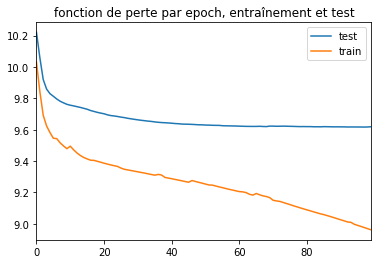

In [45]:
train_table.plot(title = 'fonction de perte par epoch, entraînement et test')
plt.savefig('magni.png', transparent=True)